# Storm Detection

## Setup
**Note:** This Notebook must be run in a UC Lab machine as it needs access to the CSSE Research drive. You also may need to gain read access from Richard to the drive.

### Imports

In [1]:
%matplotlib inline

import os
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix

from Models.Snowstorm.train import initialize_model, train_model
from Models.Snowstorm.helper import leading_zeros, show, rand_crop, create_and_save_crops, data_transforms, classify
from Models.Snowstorm.constants import RESEARCH_DIR, CROP_SIZE, INPUT_SIZE, DATA_DIR, NUM_EPOCHS, BATCH_SIZE, \
    MODEL_NAME, FEATURE_EXTRACT
from Models.Snowstorm.intervals import all_clears, all_storms
from Models.Snowstorm.cf_matrix import make_confusion_matrix

/csse/users/fdi19/miniconda3/envs/seal_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Example Images

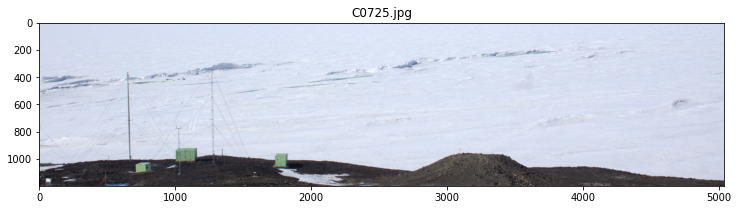

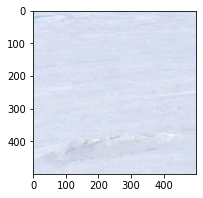

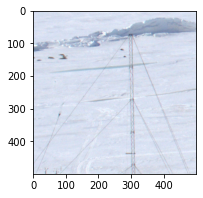

In [2]:
camera_id = 'C'

img_dir = f'{RESEARCH_DIR}/Camera{camera_id}'
filename = random.choice(os.listdir(img_dir))
path = os.path.join(img_dir, filename)

img = cv2.imread(path)
show(img, title=filename)
for _ in range(2):
    cropped_image = rand_crop(img, CROP_SIZE)
    show(cropped_image)

## Preperation

### Print Dataset Size

In [8]:
def count(data):
    total_count = 0
    cam_counts = {}
    for cam_id, storms in data.items():
        cam_counts[cam_id] = 0
        cam_count = 0  # Count of storm/clear images per Camera
        for _, intervals in storms:
            for start, end in intervals:
                cam_counts[cam_id] += (end - start + 1)
    return cam_counts

all_storms_counts = count(all_storms)
print(f'Total Storm Images: {sum(all_storms_counts.values())}')
print('\n'.join([f'Camera {k}: {v}' for k, v in all_storms_counts.items()]))

all_clears_counts = count(all_clears)
print(f'\nTotal Clear Images: {sum(all_clears_counts.values())}')
print('\n'.join([f'Camera {k}: {v}' for k, v in all_clears_counts.items()]))

Total Storm Images: 388
Camera A: 146
Camera B: 145
Camera C: 97

Total Clear Images: 505
Camera A: 168
Camera B: 185
Camera C: 152


### Create Augmentations
#### Remove existing data

In [7]:
!find data/ ! -name '.*' ! -type d -exec rm -- {} +

#### Create new data

In [9]:
create_and_save_crops(is_storm=True)
create_and_save_crops(is_storm=False)

146 images of storm/clear from Camera A
730 total augmentations saved to 'data/all/storm'

145 images of storm/clear from Camera B
725 total augmentations saved to 'data/all/storm'

97 images of storm/clear from Camera C
485 total augmentations saved to 'data/all/storm'

Total augmentation count: 1940

168 images of storm/clear from Camera A
840 total augmentations saved to 'data/all/clear'

185 images of storm/clear from Camera B
925 total augmentations saved to 'data/all/clear'

152 images of storm/clear from Camera C
760 total augmentations saved to 'data/all/clear'

Total augmentation count: 2525



### Split Data
Split data into Training Validation and Testing sets.

In [11]:
!ls data/all/storm | wc -l | xargs -i echo 'Total Storm Images: {}'
!ls data/all/storm | wc -l | xargs -i echo  '{} * 0.70' | bc | xargs -i echo '70%: {}'
!ls data/all/storm | wc -l | xargs -i echo  '{} * 0.15' | bc | xargs -i echo '15%: {}'

!echo
!ls data/all/clear | wc -l | xargs -i echo 'Total Clear Images: {}'
!ls data/all/clear | wc -l | xargs -i echo  '{} * 0.70' | bc | xargs -i echo '70%: {}'
!ls data/all/clear | wc -l | xargs -i echo  '{} * 0.15' | bc | xargs -i echo '15%: {}'

Total Storm Images: 1940
70%: 1358.00
15%: 291.00

Total Clear Images: 2360
70%: 1652.00
15%: 354.00


In [12]:
!cd data && ls all/storm | shuf -n 1358 | xargs -i mv all/storm/{} train/storm
!cd data && ls all/storm | shuf -n 291 | xargs -i mv all/storm/{} val/storm
!cd data && ls all/storm | shuf -n 291 | xargs -i mv all/storm/{} test/storm

!cd data && ls all/clear | shuf -n 1652 | xargs -i mv all/clear/{} train/clear
!cd data && ls all/clear | shuf -n 354 | xargs -i mv all/clear/{} val/clear
!cd data && ls all/clear | shuf -n 354 | xargs -i mv all/clear/{} test/clear

## Train Model

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

In [15]:
# Initialize the model for this run
model = initialize_model(use_pretrained=True)

# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if FEATURE_EXTRACT:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


### Start Training & Graph Progress

Epoch 0/14
----------
train Loss: 0.3000 Acc: 0.8708 F1: 0.8556
val Loss: 0.1001 Acc: 0.9643 F1: 0.9594

Epoch 1/14
----------
train Loss: 0.2479 Acc: 0.9063 F1: 0.8956
val Loss: 0.1098 Acc: 0.9643 F1: 0.9608

Epoch 2/14
----------
train Loss: 0.2396 Acc: 0.9037 F1: 0.8930
val Loss: 0.0921 Acc: 0.9659 F1: 0.9610

Epoch 3/14
----------
train Loss: 0.2268 Acc: 0.9156 F1: 0.9067
val Loss: 0.0878 Acc: 0.9752 F1: 0.9719

Epoch 4/14
----------
train Loss: 0.2452 Acc: 0.9096 F1: 0.8999
val Loss: 0.0826 Acc: 0.9752 F1: 0.9719

Epoch 5/14
----------
train Loss: 0.2117 Acc: 0.9159 F1: 0.9070
val Loss: 0.0784 Acc: 0.9783 F1: 0.9754

Epoch 6/14
----------
train Loss: 0.2253 Acc: 0.9143 F1: 0.9048
val Loss: 0.0723 Acc: 0.9752 F1: 0.9726

Epoch 7/14
----------
train Loss: 0.2294 Acc: 0.9113 F1: 0.9013
val Loss: 0.0717 Acc: 0.9767 F1: 0.9743

Epoch 8/14
----------
train Loss: 0.2313 Acc: 0.9136 F1: 0.9038
val Loss: 0.1053 Acc: 0.9674 F1: 0.9628

Epoch 9/14
----------
train Loss: 0.2278 Acc: 0.9123 F1

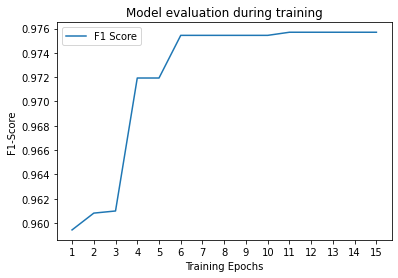

In [15]:
# Setup the loss fxn
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, device, num_epochs=NUM_EPOCHS, is_inception=(MODEL_NAME=="inception"))

# Plot improvement
acc_hist, f1_hist = zip(*hist)
plt.title("Model evaluation during training")
plt.xlabel("Training Epochs")
plt.ylabel("F1-Score")
# plt.plot(range(1,NUM_EPOCHS+1),acc_hist,label="Accuracy")
plt.plot(range(1,NUM_EPOCHS+1),f1_hist,label="F1 Score")
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()

### Save Model

In [159]:
torch.save(model.state_dict(), './storm_model.pt')

### Load Model

In [2]:
model = initialize_model(use_pretrained=True)
model = model.to(device)
model.load_state_dict(torch.load('./storm_model.pt'))
model.eval()

/csse/users/fdi19/miniconda3/envs/seal_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/csse/users/fdi19/miniconda3/envs/seal_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'device' is not defined

## Evaluation

### Accuracy

In [17]:
correct = 0
total = 0
classes = ['clear', 'storm']
for _class in classes:
    data_dir = 'data/test/' + _class
    files = os.listdir(data_dir)
    total += len(files)
    for file in files:  
        path = os.path.join(data_dir, file)    

        img = Image.open(path)

        img_t = data_transforms['val'](img)
        batch_t = torch.unsqueeze(img_t, 0)
        batch_t = batch_t.to(device)

        model.eval()

        out = model(batch_t)

        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
        _, index = torch.max(out, 1)

        if classes[index[0]] == _class:
            correct += 1
#         else:
#             show(np.asarray(img), scale=2, rgb_convert=False, title=f'{file.split(".")[0]} {classes[index[0]]} {percentage[index[0]].item():.2f}%')

print(f'{correct / total * 100:.2f}% Accuracy')

97.21% Accuracy


### Test Random Image

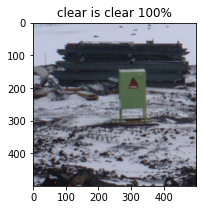

In [19]:
data_dir = 'data/test'
_class = random.choice(classes)
path = f'{data_dir}/{_class}/'
file = random.choice(os.listdir(path))
path += file
img = Image.open(path)

output, confidence = classify(model, img, device)
show(np.asarray(img), rgb_convert=False, title=f'{_class} is {output} {confidence:.0f}%')

### Confusion Matrix

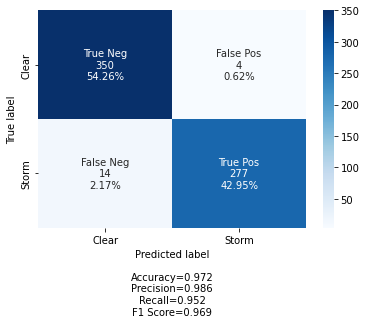

In [20]:
y_pred = []
y_true = []

model.eval()
for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    output = model(inputs)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ['Clear', 'Storm']

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf_matrix, 
                      group_names=group_names,
                      categories=classes)